I have filtered out the csv file to only include what is relevant to us which are the video IDs and their respective annotations. Since there were issues with the API trying to extract thumbnails of the video, we were able to get 783 rows in the csv but 785 images, so i have deleted the extra 2 images as well.

In [2]:
import pandas as pd
import os

# Assuming the CSV file is named 'all_results_sample.csv' and the folder containing images is mounted from Google Drive and named 'output'
csv_file = 'all_results_sample.csv'
image_folder = '/content/drive/MyDrive/output'

# Load CSV file into a DataFrame
annotations_df = pd.read_csv(csv_file)

# Extract video IDs from the 'vid_url' column
annotations_df['video_id'] = annotations_df['vid_url'].str.extract(r'(?<=v=)([\w-]+)')

# Create a new DataFrame 'id_df' with just the 'video_id' column
# Drop all columns except 'video_id' and 'annotations'
annotations_df = annotations_df[['video_id', 'normalized_annotation']].copy()

# Get a list of image names from the folder
image_names = os.listdir(image_folder)

# # Remove the '.jpg' extension from image names
image_names_without_extension = [name.replace('.jpg', '') for name in image_names]
# print(image_names_without_extension)
print(len(image_names_without_extension))

filtered_annotations_df = annotations_df[annotations_df['video_id'].isin(image_names_without_extension)]
filtered_annotations_df

# Keep only unique values of 'video_id' in filtered_annotations_df
filtered_annotations_df = filtered_annotations_df.drop_duplicates(subset=['video_id'])

# Get the list of unique video IDs in filtered_annotations_df
unique_video_ids = filtered_annotations_df['video_id'].unique()

# Now filtered_annotations_df contains only unique values of 'video_id'
# Get the list of image names to delete
images_to_delete = [name + '.jpg' for name in image_names_without_extension if name not in unique_video_ids]

# Delete the images from the folder
for image_name in images_to_delete:
    image_path = os.path.join(image_folder, image_name)
    os.remove(image_path)

print(f"Deleted {len(images_to_delete)} images from the folder.")

783
Deleted 0 images from the folder.


In [3]:
# Path to save the final CSV file
output_csv_file = 'filtered_annotations.csv'

# Save the final DataFrame to a CSV file
filtered_annotations_df.to_csv(output_csv_file, index=False)

print(f"Filtered annotations saved to {output_csv_file}.")

Filtered annotations saved to filtered_annotations.csv.


Pair images with their respective annotations with video_id as the common link, handle X and Y, split into train, test and val, convert the list(X & Y) to np array as that is what the NN would understand



In [4]:
import cv2
data = []
for index, row in filtered_annotations_df.iterrows():
    video_id = row['video_id']
    annotation = row['normalized_annotation']
    image_index = image_names_without_extension.index(video_id)
    image_path = os.path.join(image_folder, image_names[image_index])
    image = cv2.imread(image_path)  # Read image using OpenCV
    data.append((image, annotation))

In [5]:
data_size = len(data)
print("Size of the data:", data_size)

Size of the data: 783


In [6]:
# Separate X and Y from data
X = [item[0] for item in data]  # Extract images from the tuples
Y = [item[1] for item in data]  # Extract annotations from the tuples

In [7]:
# Convert labels from -1, 0, 1 to 0, 1, 2
Y = [label + 1 for label in Y]

In [8]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [9]:
import numpy as np

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

Neural Networks(less layers)

Epoch 1/20
16/16 [==============================] - 18s 1s/step - loss: 16173.8047 - accuracy: 0.4280 - val_loss: 12905.5996 - val_accuracy: 0.6190
Epoch 2/20
16/16 [==============================] - 23s 1s/step - loss: 6220.0684 - accuracy: 0.4480 - val_loss: 2904.4934 - val_accuracy: 0.6111
Epoch 3/20
16/16 [==============================] - 12s 733ms/step - loss: 2425.9810 - accuracy: 0.5040 - val_loss: 1098.9529 - val_accuracy: 0.4841
Epoch 4/20
16/16 [==============================] - 14s 872ms/step - loss: 1864.4717 - accuracy: 0.5360 - val_loss: 1061.4780 - val_accuracy: 0.5476
Epoch 5/20
16/16 [==============================] - 14s 880ms/step - loss: 2456.6145 - accuracy: 0.5100 - val_loss: 3480.2842 - val_accuracy: 0.2937
Epoch 6/20
16/16 [==============================] - 13s 789ms/step - loss: 1568.2924 - accuracy: 0.5700 - val_loss: 1886.1200 - val_accuracy: 0.2937
Epoch 7/20
16/16 [==============================] - 12s 788ms/step - loss: 2756.1899 - accuracy: 0.5360 - val_

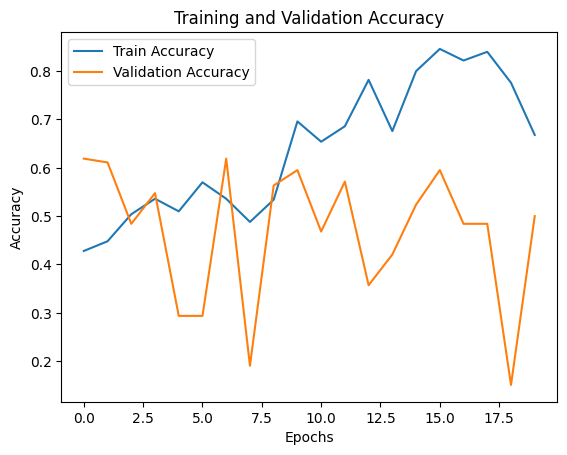

5/5 [==============================] - 0s 67ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.28      0.29        50
           1       0.51      0.67      0.58        84
           2       0.50      0.04      0.08        23

    accuracy                           0.45       157
   macro avg       0.44      0.33      0.32       157
weighted avg       0.45      0.45      0.42       157

Average Accuracy: 0.45222929936305734


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(320, 320, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 units for 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multi-class classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))


Neural Networks(more layers)

Epoch 1/20
16/16 [==============================] - 46s 2s/step - loss: 2098.2808 - accuracy: 0.2740 - val_loss: 1041.9816 - val_accuracy: 0.5873
Epoch 2/20
16/16 [==============================] - 25s 2s/step - loss: 865.1217 - accuracy: 0.3660 - val_loss: 213.9488 - val_accuracy: 0.5159
Epoch 3/20
16/16 [==============================] - 30s 2s/step - loss: 734.9161 - accuracy: 0.4960 - val_loss: 128.9062 - val_accuracy: 0.4524
Epoch 4/20
16/16 [==============================] - 28s 2s/step - loss: 193.2515 - accuracy: 0.4720 - val_loss: 292.8013 - val_accuracy: 0.6190
Epoch 5/20
16/16 [==============================] - 26s 2s/step - loss: 388.6061 - accuracy: 0.4580 - val_loss: 146.4482 - val_accuracy: 0.1746
Epoch 6/20
16/16 [==============================] - 25s 2s/step - loss: 172.2083 - accuracy: 0.5400 - val_loss: 113.5811 - val_accuracy: 0.5794
Epoch 7/20
16/16 [==============================] - 26s 2s/step - loss: 117.9507 - accuracy: 0.5340 - val_loss: 242.7045 - val_accurac

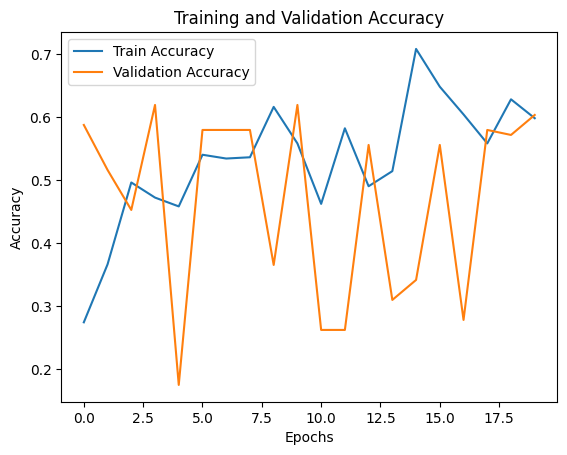

5/5 [==============================] - 1s 139ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.54      0.99      0.69        84
           2       1.00      0.04      0.08        23

    accuracy                           0.54       157
   macro avg       0.51      0.34      0.26       157
weighted avg       0.43      0.54      0.38       157

Average Accuracy: 0.535031847133758


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(320, 320, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multi-class classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

CNN architecture defined(simple), more complex required more RAM, hence skipped


Epoch 1/5
16/16 [==============================] - 264s 16s/step - loss: 763.2723 - accuracy: 0.3960 - val_loss: 1.1656 - val_accuracy: 0.3651
Epoch 2/5
16/16 [==============================] - 265s 17s/step - loss: 1.0738 - accuracy: 0.5500 - val_loss: 1.0524 - val_accuracy: 0.4524
Epoch 3/5
16/16 [==============================] - 261s 16s/step - loss: 0.9672 - accuracy: 0.6080 - val_loss: 1.0723 - val_accuracy: 0.5952
Epoch 4/5
16/16 [==============================] - 260s 16s/step - loss: 0.8702 - accuracy: 0.7120 - val_loss: 1.2322 - val_accuracy: 0.5873
Epoch 5/5
16/16 [==============================] - 253s 16s/step - loss: 0.6571 - accuracy: 0.7860 - val_loss: 1.6690 - val_accuracy: 0.5476


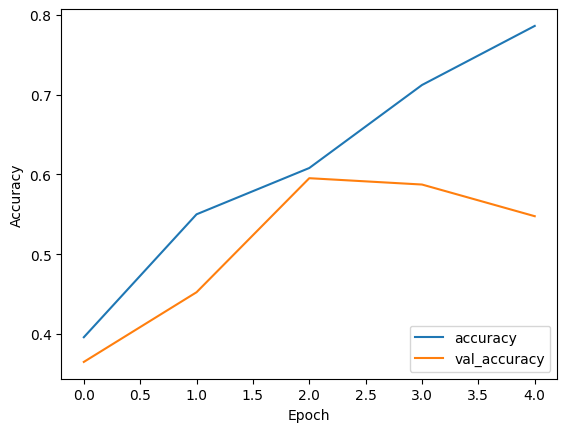

5/5 [==============================] - 18s 4s/step
              precision    recall  f1-score   support

           0       0.32      0.26      0.29        50
           1       0.48      0.63      0.55        84
           2       0.50      0.13      0.21        23

    accuracy                           0.44       157
   macro avg       0.43      0.34      0.35       157
weighted avg       0.43      0.44      0.41       157

Average Accuracy: 0.4394904458598726


In [12]:
# Define CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(320, 320, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes, so 3 units in the output layer
])


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),

loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))
# Plot learning curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))

CNN with regularization


Epoch 1/5
16/16 [==============================] - 303s 18s/step - loss: 344.2430 - accuracy: 0.3940 - val_loss: 10.7842 - val_accuracy: 0.6349
Epoch 2/5
16/16 [==============================] - 265s 17s/step - loss: 11.7906 - accuracy: 0.6260 - val_loss: 12.4611 - val_accuracy: 0.6746
Epoch 3/5
16/16 [==============================] - 264s 17s/step - loss: 12.1939 - accuracy: 0.7480 - val_loss: 12.5843 - val_accuracy: 0.6429
Epoch 4/5
16/16 [==============================] - 260s 16s/step - loss: 11.4859 - accuracy: 0.8880 - val_loss: 12.3634 - val_accuracy: 0.5317
Epoch 5/5
16/16 [==============================] - 260s 16s/step - loss: 10.9676 - accuracy: 0.9480 - val_loss: 13.7094 - val_accuracy: 0.6032


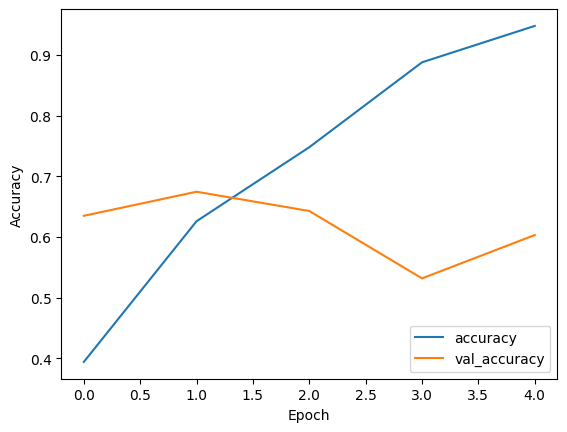

5/5 [==============================] - 29s 4s/step
              precision    recall  f1-score   support

           0       0.46      0.22      0.30        50
           1       0.54      0.82      0.65        84
           2       0.00      0.00      0.00        23

    accuracy                           0.51       157
   macro avg       0.33      0.35      0.32       157
weighted avg       0.44      0.51      0.44       157

Average Accuracy: 0.5095541401273885


In [13]:
from tensorflow.keras import regularizers

# Define CNN architecture with L2 regularization
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(320, 320, 3), kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes, so 3 units in the output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

# Plot learning curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))


1. pre-trained well known CNN model, This code loads the pre-trained VGG16 model without the top layer, adds custom top layers for classification, freezes the pre-trained layers, compiles the model, and trains it. Finally, it evaluates the model on the test data and prints the classification report and accuracy score.

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

# Load pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/5
16/16 [==============================] - 713s 45s/step - loss: 28.7486 - accuracy: 0.4740 - val_loss: 3.1792 - val_accuracy: 0.5159
Epoch 2/5
16/16 [==============================] - 716s 45s/step - loss: 1.0999 - accuracy: 0.7660 - val_loss: 1.6023 - val_accuracy: 0.5159
Epoch 3/5
16/16 [==============================] - 708s 45s/step - loss: 0.3989 - accuracy: 0.8300 - val_loss: 1.7788 - val_accuracy: 0.6111
Epoch 4/5
16/16 [==============================] - 705s 45s/step - loss: 0.3096 - accuracy: 0.8600 - val_loss: 2.0834 - val_accuracy: 0.6190
Epoch 5/5
5/5 [==============================] - 175s 34s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.10      0.16        50
           1       0.56      0.95      0.70        84
           2       0.00      0.00      0.00        23

    accuracy                           0.54       157
   macro avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1. fine tuning, This code unfreezes the last four layers of the base model (you can adjust the number of layers to unfreeze based on your requirements), lowers the learning rate for fine-tuning, compiles the model with the lower learning rate, and trains the model for additional epochs. Finally, it evaluates the fine-tuned model on the test data and prints the classification report and accuracy score.







In [15]:
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Lower the learning rate for fine-tuning
fine_tune_lr = 1e-5

# Compile the model with the lower learning rate
model.compile(optimizer=Adam(learning_rate=fine_tune_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for additional epochs for fine-tuning
fine_tune_epochs = 5
history_fine_tune = model.fit(X_train, Y_train, epochs=fine_tune_epochs, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the fine-tuned model on the test data
y_pred_fine_tune = model.predict(X_test)
y_pred_classes_fine_tune = np.argmax(y_pred_fine_tune, axis=1)
print("Classification Report (Fine-tuned Model):")
print(classification_report(Y_test, y_pred_classes_fine_tune))
print("Average Accuracy (Fine-tuned Model):", accuracy_score(Y_test, y_pred_classes_fine_tune))

Epoch 1/5
16/16 [==============================] - 806s 51s/step - loss: 0.2152 - accuracy: 0.8860 - val_loss: 2.5138 - val_accuracy: 0.6270
Epoch 3/5
16/16 [==============================] - 798s 50s/step - loss: 0.1944 - accuracy: 0.8880 - val_loss: 2.9022 - val_accuracy: 0.6349
Epoch 4/5
16/16 [==============================] - 809s 51s/step - loss: 0.1848 - accuracy: 0.8900 - val_loss: 3.2440 - val_accuracy: 0.6190
Epoch 5/5
5/5 [==============================] - 181s 35s/step
Classification Report (Fine-tuned Model):
              precision    recall  f1-score   support

           0       0.41      0.14      0.21        50
           1       0.55      0.92      0.69        84
           2       0.00      0.00      0.00        23

    accuracy                           0.54       157
   macro avg       0.32      0.35      0.30       157
weighted avg       0.43      0.54      0.43       157

Average Accuracy (Fine-tuned Model): 0.535031847133758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2. demonstrates the use of RMSprop optimizer with a learning rate scheduling callback for fine-tuning.



In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, accuracy_score

# Load pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with RMSprop optimizer and learning rate scheduling
initial_lr = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define learning rate scheduler
def lr_scheduler(epoch):
    return initial_lr * 0.95 ** epoch  # Exponential decay

# Train the model with learning rate scheduling
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val),
                    callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))

Epoch 1/5
16/16 [==============================] - 694s 44s/step - loss: 58.8772 - accuracy: 0.4820 - val_loss: 1.0803 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 2/5
16/16 [==============================] - 700s 44s/step - loss: 0.6175 - accuracy: 0.7200 - val_loss: 1.8374 - val_accuracy: 0.5952 - lr: 9.5000e-04
Epoch 3/5
16/16 [==============================] - 696s 44s/step - loss: 0.4156 - accuracy: 0.7880 - val_loss: 1.2529 - val_accuracy: 0.5714 - lr: 9.0250e-04
Epoch 4/5
16/16 [==============================] - 697s 44s/step - loss: 0.3572 - accuracy: 0.8320 - val_loss: 1.3886 - val_accuracy: 0.5397 - lr: 8.5737e-04
Epoch 5/5
5/5 [==============================] - 184s 36s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.18      0.24        50
           1       0.57      0.90      0.70        84
           2       0.00      0.00      0.00        23

    accuracy                           0.54       157
   macro avg 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2. ResNet

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
16/16 [==============================] - 340s 20s/step - loss: 29.2486 - accuracy: 0.4640 - val_loss: 4.9020 - val_accuracy: 0.5794
Epoch 2/5
16/16 [==============================] - 306s 19s/step - loss: 1.6863 - accuracy: 0.7720 - val_loss: 1.1496 - val_accuracy: 0.3651
Epoch 3/5
16/16 [==============================] - 279s 18s/step - loss: 0.5254 - accuracy: 0.8080 - val_loss: 1.5594 - val_accuracy: 0.6032
Epoch 4/5
16/16 [==============================] - 282s 18s/step - loss: 0.3555 - accuracy: 0.8620 - val_loss: 1.6565 - val_accuracy: 0.6190
Epoch 5/5
5/5 [==============================] - 67s 13s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.06      0.11        50
           1       0.55      0.96      0.70        84
           2       0.50      0.09      0.15        23

    accuracy                           0.55       157
   macro avg 

In [18]:
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Lower the learning rate for fine-tuning
fine_tune_lr = 1e-5

# Compile the model with the lower learning rate
model.compile(optimizer=Adam(learning_rate=fine_tune_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for additional epochs for fine-tuning
fine_tune_epochs = 5
history_fine_tune = model.fit(X_train, Y_train, epochs=fine_tune_epochs, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the fine-tuned model on the test data
y_pred_fine_tune = model.predict(X_test)
y_pred_classes_fine_tune = np.argmax(y_pred_fine_tune, axis=1)
print("Classification Report (Fine-tuned Model):")
print(classification_report(Y_test, y_pred_classes_fine_tune))
print("Average Accuracy (Fine-tuned Model):", accuracy_score(Y_test, y_pred_classes_fine_tune))

Epoch 1/5
16/16 [==============================] - 330s 20s/step - loss: 0.1939 - accuracy: 0.9320 - val_loss: 2.1137 - val_accuracy: 0.6270
Epoch 2/5
16/16 [==============================] - 321s 20s/step - loss: 0.1889 - accuracy: 0.9260 - val_loss: 2.2762 - val_accuracy: 0.6349
Epoch 3/5
16/16 [==============================] - 311s 20s/step - loss: 0.1862 - accuracy: 0.9320 - val_loss: 2.3725 - val_accuracy: 0.6429
Epoch 4/5
16/16 [==============================] - 311s 20s/step - loss: 0.1846 - accuracy: 0.9340 - val_loss: 2.4670 - val_accuracy: 0.6429
Epoch 5/5
5/5 [==============================] - 74s 15s/step
Classification Report (Fine-tuned Model):
              precision    recall  f1-score   support

           0       0.53      0.20      0.29        50
           1       0.55      0.89      0.68        84
           2       0.50      0.04      0.08        23

    accuracy                           0.55       157
   macro avg       0.53      0.38      0.35       157
weight

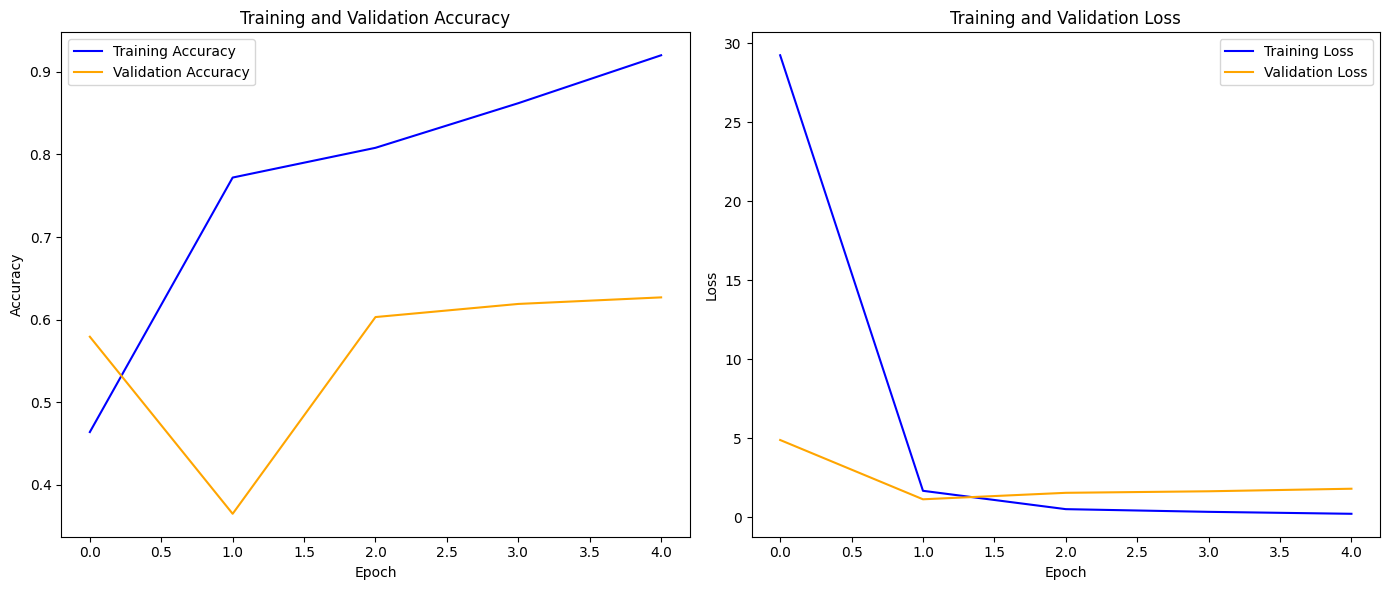

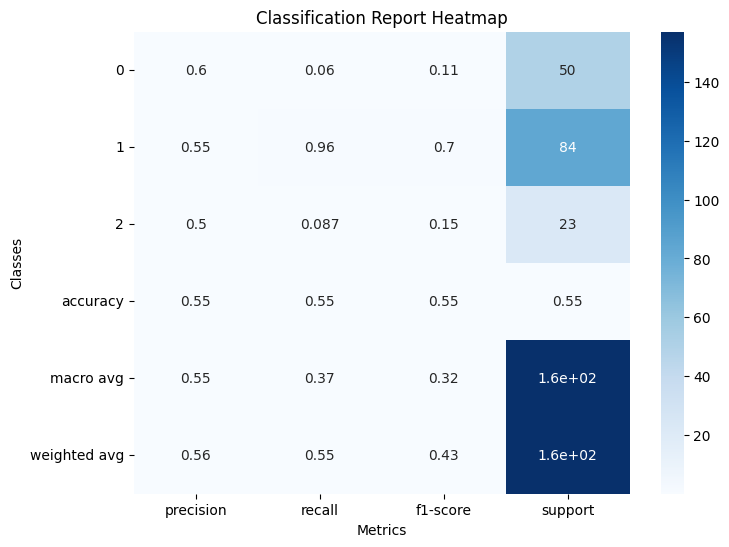

Average Accuracy: 0.5477707006369427


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Plot learning curves
plt.figure(figsize=(14, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate the classification report
report_dict = classification_report(Y_test, y_pred_classes, output_dict=True)

# Convert the report dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap='Blues')
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

# Print average accuracy
avg_accuracy = accuracy_score(Y_test, y_pred_classes)
print("Average Accuracy:", avg_accuracy)

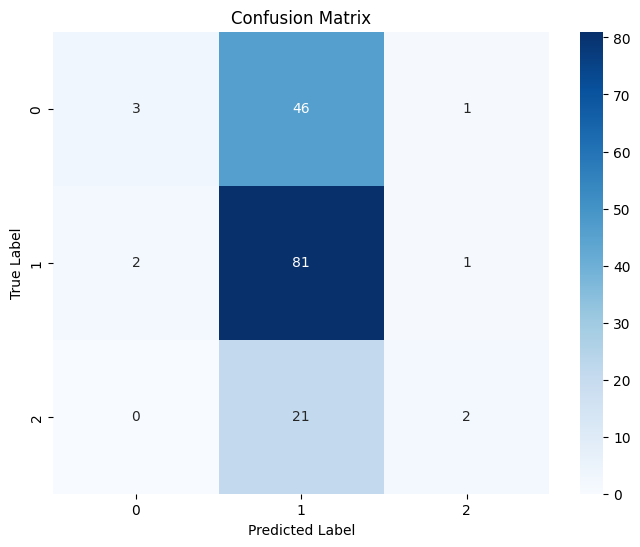

In [26]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_mat = confusion_matrix(Y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()